In [1]:
import sympy as sy
time, x, xdot, delta = sy.symbols('t x_1 x_2 \\delta')

from sympy import latex
from IPython.display import display_latex

def disp(idx, symObj):
    eqn = '\\[' + idx + ' ' + latex(symObj) + '\\]'
    display_latex(eqn,raw=True)
    return

from IPython.display import display_latex
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, least_squares

import ssmlearnpy.reduced_dynamics.normalform as normalform
from ssmlearnpy.utils import ridge
from ssmlearnpy.reduced_dynamics.shift_or_differentiate import shift_or_differentiate
from scipy.io import savemat, loadmat

import logging
logger = logging.getLogger("ridge_regression")
logger.setLevel(logging.WARNING)

We consider the following nonlinear ODE

$$
\ddot{x} = -x - \delta (x^2 - 1) \dot{x},
$$

In first order form, the vector field reads

In [2]:
RHS = sy.Matrix([xdot, -x - delta*xdot*x**2 + delta*xdot])
disp('\\frac{d}{dt}\\begin{pmatrix}x_1 \\\ x_2 \\end{pmatrix}=',RHS)

Its Jacobian at the fixed point is

In [3]:
J = RHS.jacobian([x, xdot]).subs([(x, 0), (xdot, 0)])
disp('J=', J)

which has eigenvalues

In [4]:
eigenvals = J.eigenvals(multiple = True)
for e in eigenvals:
    disp('\\lambda = ', e)

In [5]:
deltaa = 0.1

For damping $\delta = 0.1$, we have

$$
\lambda = 0.05\pm0.998749218𝑖
$$

### Create data

In [6]:
def vectorfield(t,x):
    return np.array([x[1],-x[0] - deltaa*x[1]*(x[0]**2 - 1.0)])

In [7]:
t = np.linspace(0, 100, 1001)
dt = t[1] - t[0]

In [8]:
# Initial conditions
ic_0 = np.array([4.0, 4.0])
ic_1 = np.array([-4.0, 4.0])
ic_2 = np.array([4.0, -4.0])
ic_3 = np.array([-4.0, -4.0])

In [9]:
# Numerical solutions
sol_0 = solve_ivp(vectorfield, [t[0], t[-1]], ic_0, t_eval=t)
sol_1 = solve_ivp(vectorfield, [t[0], t[-1]], ic_1, t_eval=t)
sol_2 = solve_ivp(vectorfield, [t[0], t[-1]], ic_2, t_eval=t)
sol_3 = solve_ivp(vectorfield, [t[0], t[-1]], ic_3, t_eval=t)

In [10]:
# Reshape solutions into array "trajectories"
trajectories = [sol_0.y - np.array([1,0]).reshape(-1,1), sol_1.y - np.array([1,0]).reshape(-1,1), sol_2.y - np.array([1,0]).reshape(-1,1), sol_3.y - np.array([1,0]).reshape(-1,1)]
# Array containing time spawn
times = [t, t, t, t]

In [11]:
# Reshape solutions into array "trajectories"
# trajectories = [sol_1.y - np.array([1,0]).reshape(-1,1), sol_3.y - np.array([1,0]).reshape(-1,1)]
# Array containing time spawn
# times = [t, t]

### Plot data

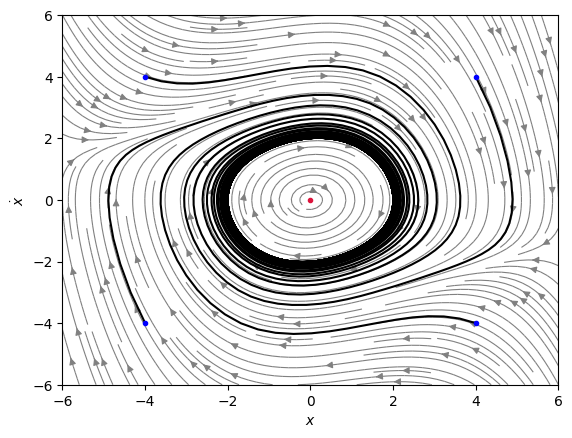

In [12]:
xx = np.linspace(-6, 6, 30)
yy = np.linspace(-6, 6, 30)
Xmesh, Ymesh = np.meshgrid(xx, yy)
grid = np.vstack((Xmesh.ravel(), Ymesh.ravel()))
U, V = vectorfield(0, grid)
U = U.reshape(Xmesh.shape)
V = V.reshape(Xmesh.shape)

plt.streamplot(Xmesh, Ymesh, U, V, color='grey', linewidth = 0.8, density = 2)
plt.xlabel('$x$')
plt.ylabel('$\\dot{x}$')

for t in trajectories:
    plt.plot(t[0,:]+1, t[1,:], '-', c='black')
plt.plot(0,0, '.', c='crimson')
plt.plot(ic_0[0],ic_0[1], '.', c='blue')
plt.plot(ic_1[0],ic_1[1], '.', c='blue')
plt.plot(ic_2[0],ic_2[1], '.', c='blue')
plt.plot(ic_3[0],ic_3[1], '.', c='blue')

### Fit using SSMLearn

In [13]:
# Order
polyDeg = 3
# Degrees of freedom
ndofs = 1

In [14]:
X, y  = shift_or_differentiate(trajectories, times, 'flow') 

In [15]:
# The _ array contains the trajectories
X == trajectories

True

In [16]:
# The y array contains d./dt of the trajectories
y

[array([[  4.02053289,   3.00196105,   2.06891335, ...,   1.79328479,
           1.86995374,   1.9332767 ],
        [-10.03377535,  -9.73050563,  -8.78854313, ...,   0.83592245,
           0.70160615,   0.55104301]]),
 array([[ 3.99812439,  3.85158887,  3.78201734, ..., -0.43179816,
         -0.22293753, -0.01882073],
        [-1.95879742, -1.03159757, -0.35400266, ...,  2.09910854,
          2.07484317,  2.0127876 ]]),
 array([[-3.99812439, -3.85158887, -3.78201734, ...,  0.43179816,
          0.22293753,  0.01882073],
        [ 1.95879742,  1.03159757,  0.35400266, ..., -2.09910854,
         -2.07484317, -2.0127876 ]]),
 array([[-4.02053289, -3.00196105, -2.06891335, ..., -1.79328479,
         -1.86995374, -1.9332767 ],
        [10.03377535,  9.73050563,  8.78854313, ..., -0.83592245,
         -0.70160615, -0.55104301]])]

In [17]:
# A priori knowledge
# Add the constraints to the fixed points explicitly
constLHS = [[0, 0]]
constRHS = [[0, 0]]
cons = [constLHS, constRHS]
# Such that model.prediction(LHS) = RHS

In [18]:
# Fit a ridge regression model to the data
mdl = ridge.get_fit_ridge(X, y, poly_degree = polyDeg, constraints = cons)
# mdl = ridge.get_fit_ridge(X, y, poly_degree = polyDeg)

In [19]:
# Check that the constraints are enforced
print(mdl.predict(constLHS), constRHS)

[[0. 0.]] [[0, 0]]


In [20]:
# Get an estimate of the linear part
linearPart = mdl.map_info['coefficients'][:,:2]

In [21]:
"""Minimize
    ||d\dt (y + f_normalform(y)) - \Lambda*(y+f_normalform(y)) - N_normalform(y+f_normalform)||^2
    where \Lambda is the linear part of the dynamics and N_normalform is the nonlinear part of the normal form dynamics
    f_normalform is the nonlinear part of the normal form transformation z = T^{-1}(y) = y + f_normalform(y).
    """
nf, n_unknowns_dynamics, n_unknowns_transformation, objectiv \
    = normalform.create_normalform_transform_objective(times, trajectories, linearPart, degree = polyDeg)

In [22]:
"""We do a ridge regression on the diagonalized coordinates (modal coordinates). 
    The initial condition for the optimization is taken as the modal dynamics ridge regression problem. 
    """
initial_guess = normalform.create_normalform_initial_guess(mdl, nf)

In [23]:
# Solve the objective function with the initial guess
np.random.seed(3)
res = least_squares(objectiv, initial_guess, jac='2-point', method='lm')

In [24]:
# Unpack the optimized coefficients into a dictionary
d = normalform.unpack_optimized_coeffs(res.x, ndofs, nf, n_unknowns_dynamics, n_unknowns_transformation)

Linear part for $\delta = 0.1$,

$$
\lambda = 0.05\pm0.998749218𝑖
$$

In [25]:
# Estimated linear part
print(nf.LinearPart[1,1])

(0.0024681463829206544-1.0259860598619301j)


In [26]:
# Wrap the optimized coefficients into a NonlinearCoordinateTransform object
trf, dyn = normalform.wrap_optimized_coefficients(ndofs, nf, polyDeg, d )

In [27]:
nf.LinearPart

array([[0.00246815+1.02598606j, 0.        +0.j        ],
       [0.        +0.j        , 0.00246815-1.02598606j]])

In [28]:
dyn

{'coefficients': array([[ 0.00246815+1.02598606j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ,
         -1.91238914-2.15568809j,  0.        +0.j        ,
          0.        +0.j        ]]),
 'exponents': array([[1, 0, 2, 1, 0, 3, 2, 1, 0],
        [0, 1, 0, 1, 2, 0, 1, 2, 3]]),
 'vectorfield': <function ssmlearnpy.reduced_dynamics.normalform.wrap_optimized_coefficients.<locals>.vectorfield(t, x)>}

In [29]:
trajectories[0].shape

(2, 1001)

Text(0.5, 1.0, 'Exact trajectories')

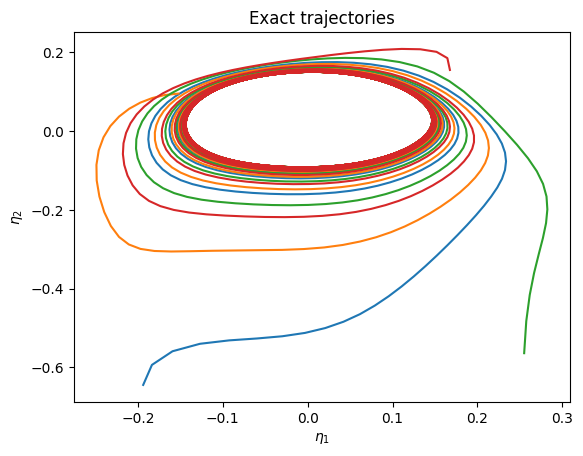

In [30]:
# Plot the trajectories in the normal form coordinates
for t in trajectories:
    transformed = trf.inverse_transform(t) 
    plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]))
plt.xlabel('$\\eta_1$')
plt.ylabel('$\\eta_2$')
plt.title('Exact trajectories')

In [31]:
time_pred = np.linspace(0, 100, 1001)

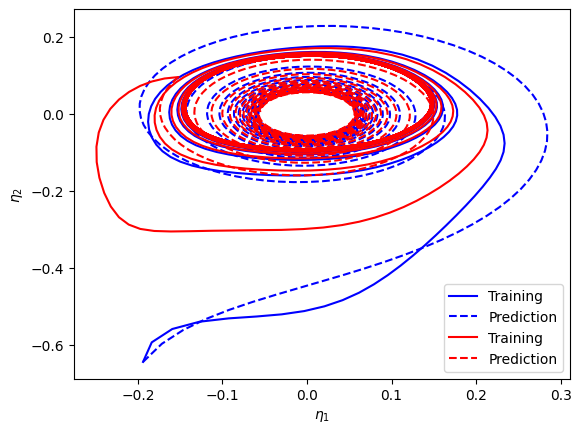

In [32]:
clit=1
for t in trajectories:
    if clit==1:
        transformed = trf.inverse_transform(t)
        plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='blue', label = 'Training')
        ic = transformed[:,0]
    
        pred = solve_ivp(dyn['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        plt.plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='blue', label = 'Prediction')
        clit+=1
    elif clit==2:
        transformed = trf.inverse_transform(t)
        plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='red', label = 'Training')
        ic = transformed[:,0]
    
        pred = solve_ivp(dyn['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        plt.plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='red', label = 'Prediction')
        clit+=1
plt.xlabel('$\\eta_1$')
plt.ylabel('$\\eta_2$')
plt.legend()

Compare the results with order = 3, 5, 7, 9

Order: 3, Residual: 3.475389419295179 

(0.0024681463829206544+1.0259860598619301j)
Order: 5, Residual: 1.4123269601398079 

(0.02014739196616525+1.185138893864078j)
Order: 7, Residual: 0.3251033879793749 

(0.04314090148512208+1.2612203696839546j)
Order: 9, Residual: 0.09061804580277626 

(0.08706632993716623+1.3325733570954665j)


Text(0, 0.5, 'Relative error [%]')

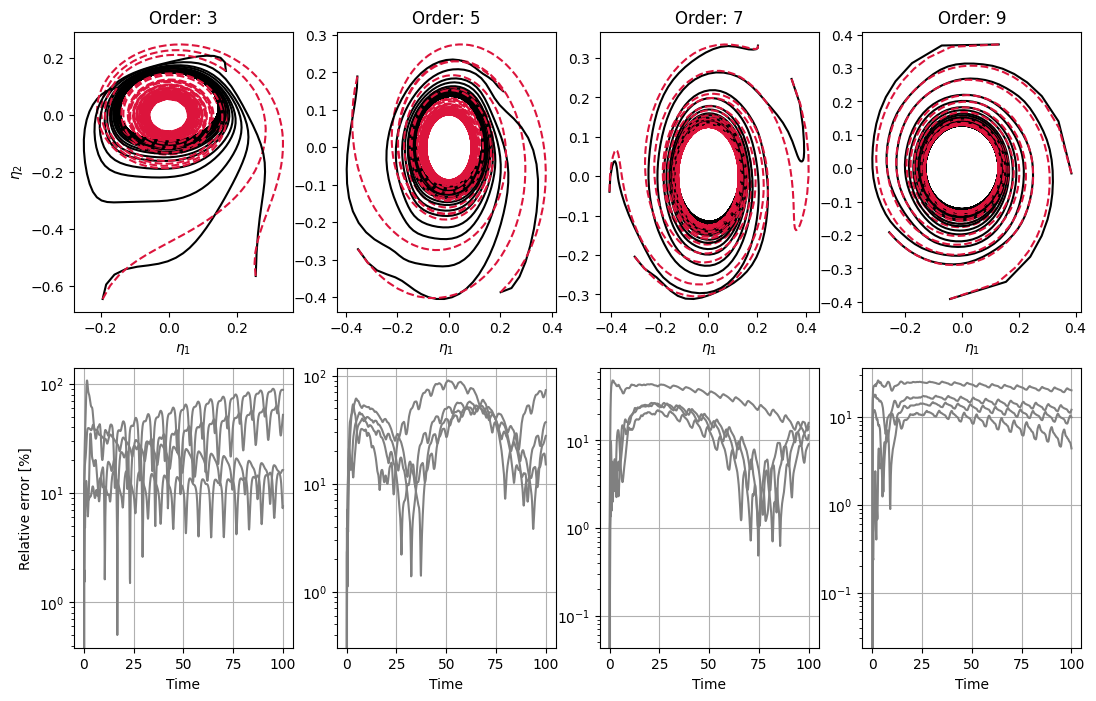

In [33]:
f,ax = plt.subplots(2,4,figsize = (13, 8))
orders = [3, 5, 7, 9]
n_orders = len(orders)
for i in range(n_orders):
    order = orders[i]
    mdl = ridge.get_fit_ridge(X, y, poly_degree = order, constraints = cons) # pre-fit with regular ridge regression
    linearPart = mdl.map_info['coefficients'][:,:2]

    nf, n_unknowns_dynamics, n_unknowns_transformation, objectiv = normalform.create_normalform_transform_objective(times, trajectories, linearPart, degree = order)
    initial_guess = normalform.create_normalform_initial_guess(mdl, nf)
    res = least_squares(objectiv, initial_guess, jac='2-point', method='lm')
    print('Order: %s, Residual: %s \n' %(order, res.cost))
    d = normalform.unpack_optimized_coeffs(res.x, ndofs, nf, n_unknowns_dynamics, n_unknowns_transformation)
    trf, dyn = normalform.wrap_optimized_coefficients(ndofs, nf, order, d )
    print(dyn["coefficients"][0][0])
    ax[0,i].set_xlabel('$\\eta_1$')
    ax[0,i].set_title('Order: %s' %order)
    for t in trajectories:
        transformed = trf.inverse_transform(t)
        ax[0,i].plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='black', label = 'Training')
        ic = transformed[:,0]
        pred = solve_ivp(dyn['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        ax[0,i].plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='Crimson', label = 'Prediction')
        ## we also compute the error along trajectories
        tonorm = np.max(np.abs(transformed[:,0]))
        error = np.abs(pred.y[0,:] - transformed[0,:])/tonorm
        ax[1,i].semilogy(pred.t, error*100, '-', c='grey', label ='Relative error')
            
    ax[1,i].grid()  
    ax[1,i].set_xlabel('Time')
ax[0,0].set_ylabel('$\\eta_2$')
ax[1,0].set_ylabel('Relative error [%]')